# Monitoramento de casos de CVID19 no Brasil.

**Este notebook tem como objetivo aplicar técnicas de análise da dados, somente para fins didáticos.**

### INFORMAÇÕES SOBRE AS BASES UTILIZADAS

* Base utilizada para extrair dados do Brasil e Estados [G1  Globo](https://g1.globo.com/bemestar/coronavirus/noticia/2020/03/27/casos-de-coronavirus-no-brasil-em-27-de-marco.ghtml) Fonte: Ministério da Saúde até 15 de março; secretarias estaduais da Saúde a partir de 16 de março.Criado com Datawrapper

* Base utilizada para extrair dados dos Municipios [brasil.io](https://brasil.io/dataset/covid19/caso) Boletins informativos baseado no Ministério da Saúde e secretarias estaduais da Saúde.

* Base utilizada para extrair dados dos Mundial  [BNO News]( https://bnonews.com/index.php/2020/03/the-latest-coronavirus-cases ) Boletins informativos baseado nos dados da OMS.

* Base utilizada para extrair dados dos Mundial [OMS]( https://who.sprinklr.com)OMS.

* Base utilizada para extrair dados dos Estados [Ministério da Saúde]( https://covid.saude.gov.br/ )

*Nenhuma copia deste notebook é permitida sem citar a fonte original.*

In [9]:
#!pip install matplotlib

In [10]:
import pandas as pd
import numpy as np
import cufflinks as cf
import wget
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import folium
from folium.plugins import Search
import os
import requests
import json
from pandas.io.json import json_normalize
from folium import plugins
from numpy import nan as NA
from plotly.offline import iplot
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
cf.go_offline()
plotly.offline.init_notebook_mode(connected=True)

## Carregamento e Tratamento dos Dados

In [11]:

################################downloads######################################################### 
url_brasil_io = 'https://brasil.io/dataset/covid19/caso?format=csv'
if os.path.exists('DB/api_br_io.csv'):
    os.remove('DB/api_br_io.csv')
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
else:
    wget.download(url_brasil_io, 'DB/api_br_io.csv')
################################################################################################### 
url_ministerio_saude = ('https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/f4c55ecfa34421c25813075ccb8f0940_Download_COVID19_20200422.csv')
if os.path.exists('DB/ministerio_saude.csv'):
    os.remove('DB/ministerio_saude.csv')
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
else:
    wget.download(url_ministerio_saude, 'DB/ministerio_saude.csv')
###############################read_csv######################################################### 
estados = pd.read_csv('DB/estados.csv', encoding='utf-8')
municipios = pd.read_csv('DB/municipios.csv', encoding='utf-8')
api_br_io = pd.read_csv('DB/api_br_io.csv')
api_br_io = api_br_io.fillna(0)
api_br_io.city_ibge_code = api_br_io.city_ibge_code.astype('int64')
url_estados = 'DB/estados.json'
cidades = pd.read_json(url_estados)
municipios_map = json_normalize(cidades.features)  
casos = pd.read_csv('DB/ministerio_saude.csv', sep=';', encoding='cp1252')

########################################################################


100% [..............................................................................] 73251 / 73251

C:\Users\joner\anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning:

pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead



In [12]:
#renomeando colunas
municipios.columns = ['city_ibge_code','city','latitude','longitude','capital','uf_code']
casos.columns = ['regiao','sigla','data','casosNovos','casosAcumulados','obitosNovos','obitosAcumulados']

#tratando nomes para fazer o merge
estados = estados[['uf', 'nome']]
estados.columns = ['state','state_name']
cidades = api_br_io.merge(municipios.drop('uf_code', axis=1), on=['city','city_ibge_code'], how='left')
cidades = cidades.merge(estados, on='state', how='left')

cidades = cidades[(cidades.is_last==True) & (cidades.city !='Importados/Indefinidos')]
dadosCidades = cidades[ cidades.latitude.notnull() ]
cidades = dadosCidades[dadosCidades.place_type == 'city']
estados_brasil = dadosCidades[dadosCidades.capital == 1.0]
saude = pd.DataFrame(casos)


### Criando dados gerais do Brasil

In [13]:
dados = saude.copy()
#dados['data'] = pd.to_datetime(dadosGeral['data'])
casosNovosDia = dados['casosNovos'].groupby(dados['data']).sum()
casosNovosDia = casosNovosDia[(casosNovosDia.index >= '2020-02-26')].reset_index()

casosNovos = dados['casosNovos'].groupby(dados['data']).sum().sort_values(ascending=True)
casosNovos = casosNovos[casosNovos>=0].reset_index().drop('data',axis=1)

obitosNovos = dados['obitosNovos'].groupby(dados['data']).sum().sort_values(ascending=True)
obitosNovos = obitosNovos[obitosNovos>=0].reset_index().drop('data',axis=1)

mortesTotal = dados['obitosAcumulados'].groupby(dados['data']).sum().sort_values(ascending=True)
mortesTotal = mortesTotal[(mortesTotal.index >= '2020-02-26')].reset_index()

casosTotal = dados['casosAcumulados'].groupby(dados['data']).sum().sort_values(ascending=True)
casosTotal = casosTotal[(casosTotal.index >= '2020-02-26')].reset_index()



In [14]:
teste = dados[['casosAcumulados','data']].groupby(dados['data']).sum()

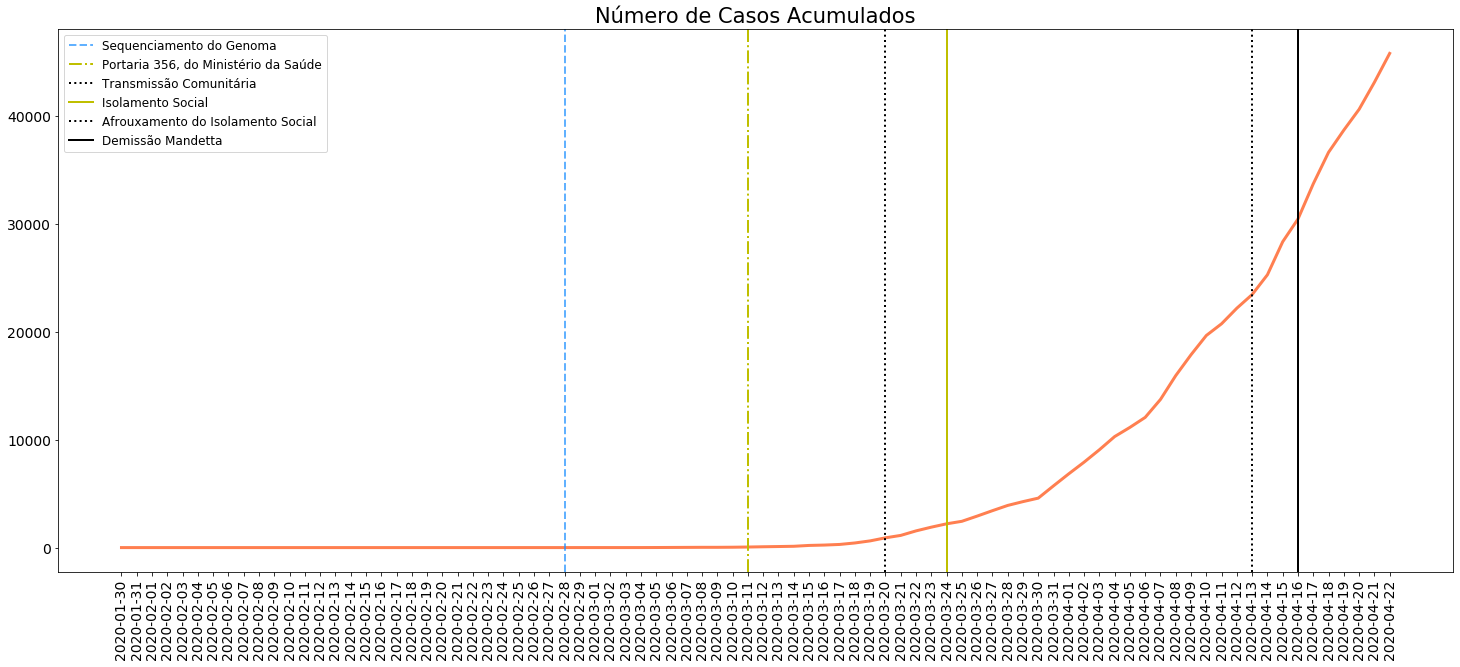

In [15]:

plt.figure(figsize=(25, 10))
plt.plot(teste.index, teste['casosAcumulados'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(teste.index, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Número de Casos Acumulados', fontsize=21)

plt.axvline(29, 0, 8000, color='dodgerblue', linestyle='--', linewidth=2, alpha=0.7, label='Sequenciamento do Genoma')
plt.axvline(41, 0, 8000, color='y', linestyle='-.', linewidth=2, alpha=1, label='Portaria 356, do Ministério da Saúde')
plt.axvline(50, 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Transmissão Comunitária')
plt.axvline(54, 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Isolamento Social')
plt.axvline(74, 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline(77, 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

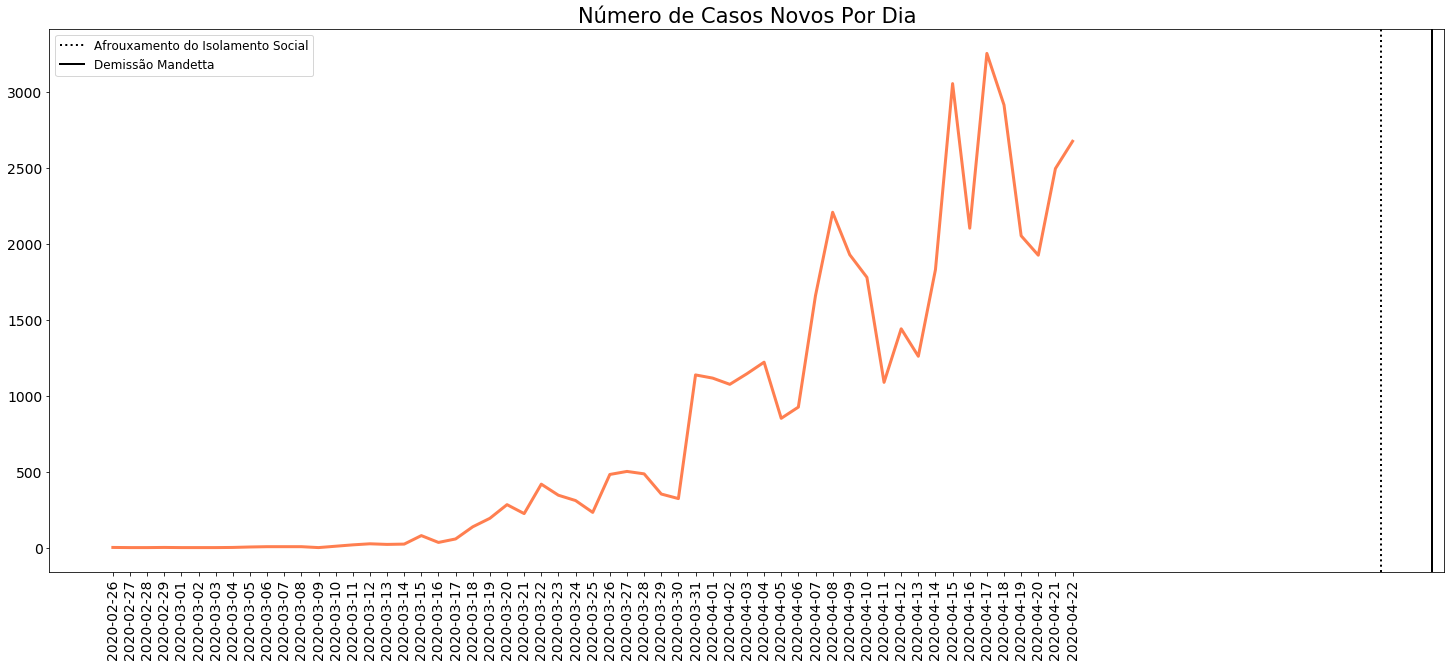

In [20]:
plt.figure(figsize=(25, 10))
plt.plot(casosNovosDia.data, casosNovosDia['casosNovos'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(casosNovosDia.data, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.axvline(74, 0, 8000, color='k', linestyle=':', linewidth=2, alpha=1, label='Afrouxamento do Isolamento Social')
plt.axvline(77, 0, 8000, color='k', linestyle='-', linewidth=2, alpha=1, label='Demissão Mandetta')
plt.title('Número de Casos Novos Por Dia', fontsize=21) 
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

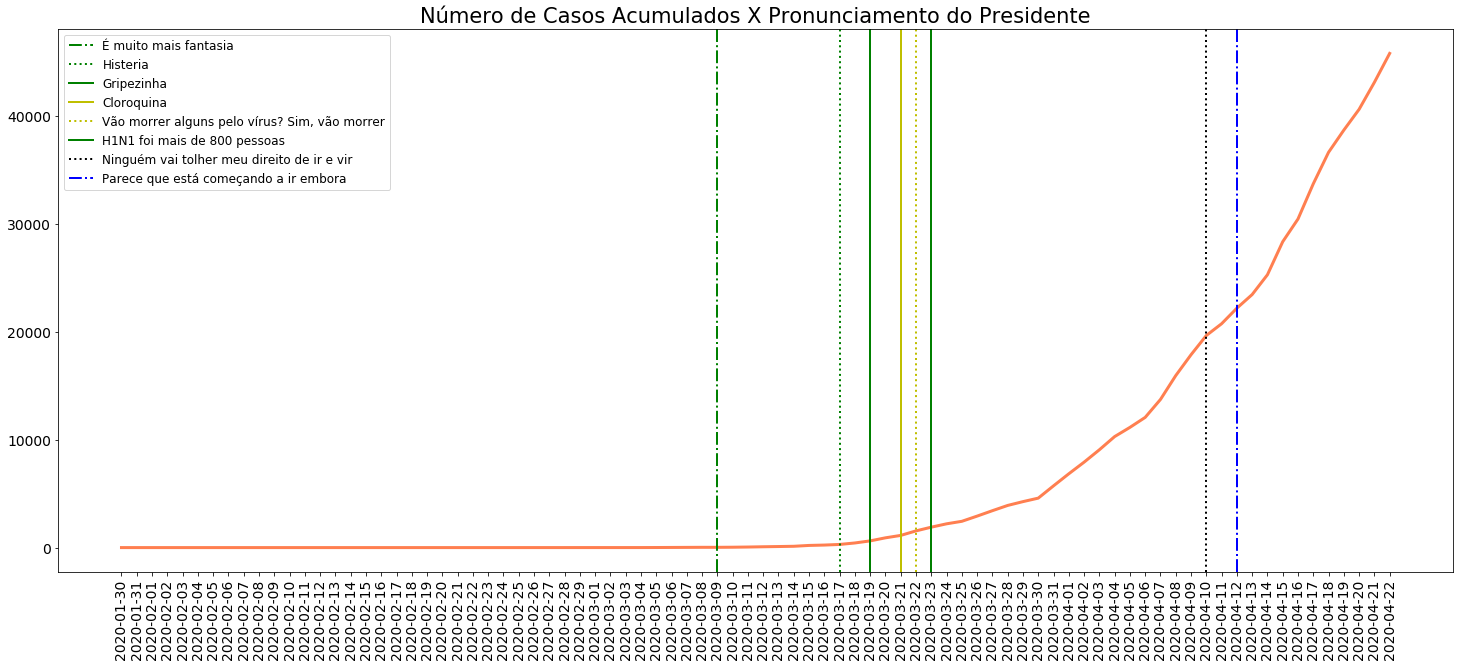

In [17]:
plt.figure(figsize=(25, 10))
plt.plot(teste.index, teste['casosAcumulados'].to_numpy(), linewidth=3, color='coral', label=None)
plt.xticks(teste.index, rotation=90, fontsize=14)
plt.yticks(fontsize=14)
plt.title('Número de Casos Acumulados X Pronunciamento do Presidente', fontsize=21)


plt.axvline(39, 0, 8000, color='g', linestyle='-.', linewidth=2, alpha=1, label='É muito mais fantasia')
plt.axvline(47, 0, 8000, color='g', linestyle='dotted', linewidth=2, alpha=1, label='Histeria')
plt.axvline(49, 0, 8000, color='g', linestyle='-', linewidth=2, alpha=1, label='Gripezinha')
plt.axvline(51, 0, 8000, color='y', linestyle='-', linewidth=2, alpha=1, label='Cloroquina')
plt.axvline(52, 0, 8000, color='y', linestyle=':', linewidth=2, alpha=1, label='Vão morrer alguns pelo vírus? Sim, vão morrer')
plt.axvline(53, 0, 8000, color='g', linestyle='-', linewidth=2, alpha=1, label='H1N1 foi mais de 800 pessoas')
plt.axvline(71, 0, 8000, color='k', linestyle='dotted', linewidth=2, alpha=1, label='Ninguém vai tolher meu direito de ir e vir')
plt.axvline(73, 0, 8000, color='b', linestyle='-.', linewidth=2, alpha=1, label='Parece que está começando a ir embora')
plt.legend(loc=2, fancybox=True, fontsize=12)
plt.show()

# Gráficos Brasil

In [21]:
from datetime import datetime
now = datetime.now()
fig1 = go.Figure(
    [
        go.Scatter(x = casosTotal.data, y = casosTotal['casosAcumulados'], mode = 'markers+lines', name="Casos acumulados"),
        go.Scatter(x = mortesTotal.data, y = mortesTotal['obitosAcumulados'], mode = 'markers+lines', name="Óbitos acumulados"),
    ]
)
config = {'displayModeBar': True}
fig1.update_layout(title='Confirmados Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
annotations=[
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=casosTotal.casosAcumulados.max(),
            xref="x",
            yref="y",
            text=casosTotal.casosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        ),
        dict(
            x=str(now.year)+'-'+str(now.month)+'-'+str(now.day-1),
            y=mortesTotal.obitosAcumulados.max(),
            xref="x",
            yref="y",
            text=mortesTotal.obitosAcumulados.max(),
            showarrow=True,
            arrowhead=7,
            ax=0,
            ay=-40
        )]
)


fig1.show()
plotly.offline.plot(fig1, filename='HTML/AcumuladoBrasilDia.html', auto_open=False)

'HTML/AcumuladoBrasilDia.html'

In [22]:
fig = go.Figure(
    [
        go.Scatter(x = dados.data, y = casosNovos['casosNovos'], mode = 'markers+lines', name="Casos novos por dia"),
        go.Scatter(x = dados.data, y = obitosNovos['obitosNovos'], mode = 'markers+lines', name="Óbitos novos por dia"),
       
    ]
)


fig.update_layout(title='Casos e Óbitos Acumulado Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white")

fig.show()
plotly.offline.plot(fig, filename='HTML/NovosCasosObitosAcumuladoBrasilDia.html', auto_open=False)

'HTML/NovosCasosObitosAcumuladoBrasilDia.html'

In [23]:
from datetime import datetime
now = datetime.now()
fig2 = go.Figure()
    
fig2.add_trace(go.Scatter(x = casosNovosDia.data, y = casosNovosDia['casosNovos'], name="Casos novos por dia",fill='tonexty'))


fig2.update_layout(title='Casos Novos Por Dia',
                   plot_bgcolor='rgb(230, 230,230)',
                   showlegend=True, template="plotly_white",
)

fig2.show()
plotly.offline.plot(fig2, filename='HTML/NovosCasosBrasilDia.html', auto_open=False)

'HTML/NovosCasosBrasilDia.html'

In [24]:
import cufflinks as cf



fig = casosNovosDia.casosNovos.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True
                                   
)
#fig = casosTotal.casosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
#fig = mortesTotal.obitosAcumulados.iplot(asFigure=True, subplots=True, shape=(4,1), shared_xaxes=True, fill=True)
fig.show()

In [25]:
fig = px.line(dados, x='data', y='casosAcumulados',color="sigla",line_group="sigla", hover_name="sigla" , text='obitosAcumulados')
fig.update_layout(title='Casos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/CasosAcumuladoEstadosDia.html', auto_open=False)

'HTML/CasosAcumuladoEstadosDia.html'

In [26]:

fig = px.line(dados, x='data', y='obitosAcumulados',color="sigla",line_group="sigla", hover_name="sigla", text='obitosAcumulados')
fig.update_layout(title='Óbitos acumulados por dia',legend_title='<b> </b>',
                   
                   showlegend=True, template="plotly_white",direction='clockwise',)
fig.show()
plotly.offline.plot(fig, filename='HTML/ObitosAcumuladoEstadosDia.html', auto_open=False)

'HTML/ObitosAcumuladoEstadosDia.html'

In [27]:

trace = go.Pie(labels = list(dados.regiao),
               values = list(dados.casosNovos),
               textinfo='percent+value'
              )

# Armazenando gráfico em uma lista:
casos = [trace]

# Criando Layout:
layout = go.Layout(title='Porcentagem de casos confirmados por Região')

# Criando figura que será exibida:
fig3 = go.Figure(data=casos, layout=layout)

py.iplot(fig3)
plotly.offline.plot(fig3, filename='HTML/PercentualAcumuladoRegiaoDia.html', auto_open=False)

'HTML/PercentualAcumuladoRegiaoDia.html'

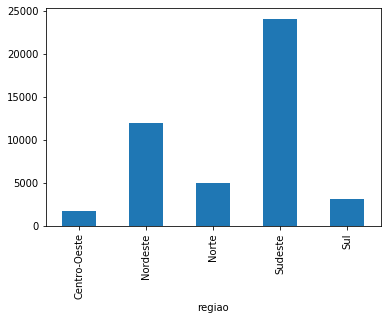

In [28]:
regiao =dados.groupby('regiao')
soma= regiao.casosNovos.sum()
soma.plot(kind='bar')



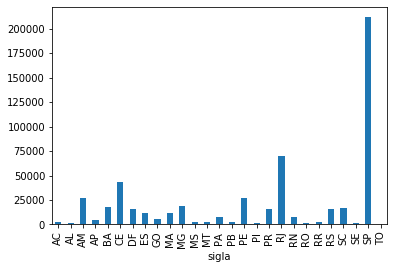

In [29]:
estados =dados.groupby('sigla')
acumuladodia= estados.casosAcumulados.sum()
acumuladodia.plot(kind='bar')

In [30]:
#api_br_io[ (api_br_io.state == 'RS')]

In [31]:
dataRS =api_br_io[ api_br_io.city.notnull() ]
rs = dataRS [ (dataRS.state == 'RS')&(dataRS.date == '2020-04-21') & (dataRS.place_type =='city')].sort_values(by='confirmed',ascending=False)
rs.groupby(['city'] )
rs.fillna(0, inplace = True)
fig = go.Figure(data=[go.Table(
    header=dict(values=['Cidades  % '+ str(round(rs.city.size*100/497,2)) +'<br><b>Total--</b>'+str(rs.city.size) +'</br>' ,
                        '<br>Confirmados</br> <b>Total-</b>'+ str(rs.confirmed.sum()),
                        '<br>Mortes</br>  <b>Total-</b>'+ str(rs.deaths.sum().astype(int))],
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[rs.city, rs.confirmed,rs.deaths],
               fill_color='lavender',
               align='left'))
])

fig.show()
plotly.offline.plot(fig, filename='HTML/TabelaCovid19RS.html', auto_open=False)

'HTML/TabelaCovid19RS.html'

In [32]:
#![Tabela1 casos confirmados por cidades do RS](IMG/Alegrete.jpg)

In [33]:
import plotly.express as px


fig = px.bar(rs.head(10), y='city', x='confirmed',color='deaths', text='confirmed',orientation='h')

fig.update_traces( textposition='outside')
fig.update_layout(uniformtext_minsize=8, uniformtext_mode='hide')
fig.show()

In [34]:
#![Figura4 Acumulado dos casos no RS e óbitos](IMG/RS.jpg)

In [35]:
import codecs
br_estados = 'DB/br_states.json'
geo_json_data = json.load(codecs.open(br_estados, 'r', 'utf-8'))
covid_cidades= cidades.copy()
covid_estados= estados_brasil.copy()
df_bsb =covid_cidades[( covid_cidades.city.notnull()) & (covid_cidades.place_type =='city') ]
df_estados =covid_estados[( covid_estados.city.notnull()) & (covid_estados.place_type =='city') ]
df_estados

,date,state,city,place_type,confirmed,deaths,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,latitude,longitude,capital,state_name
5,2020-04-21,AC,Rio Branco,city,154,7,True,407319.0,1200401,37.80820,0.0455,-9.974990,-67.8243,1.0,Acre
13,2020-04-21,AL,Maceió,city,176,13,True,1018948.0,2704302,17.27272,0.0739,-9.665990,-35.7350,1.0,Alagoas
42,2020-04-21,AM,Manaus,city,1809,163,True,2182763.0,1302603,82.87661,0.0901,-3.118660,-60.0212,1.0,Amazonas
57,2020-04-21,AP,Macapá,city,386,11,True,503327.0,1600303,76.68971,0.0285,0.034934,-51.0694,1.0,Amapá
148,2020-04-21,BA,Salvador,city,927,23,True,2872347.0,2927408,32.27326,0.0248,-12.971800,-38.5011,1.0,Bahia
201,2020-04-21,CE,Fortaleza,city,3018,176,True,2669342.0,2304400,113.06157,0.0583,-3.716640,-38.5423,1.0,Ceará
273,2020-04-21,DF,Brasília,city,850,24,True,3015268.0,5300108,28.18987,0.0282,-15.779500,-47.9297,1.0,Distrito Federal
319,2020-04-21,ES,Vitória,city,290,9,True,362097.0,3205309,80.08904,0.0310,-20.315500,-40.3128,1.0,Espírito Santo
339,2020-04-21,GO,Goiânia,city,240,10,True,1516113.0,5208707,15.82995,0.0417,-16.686400,-49.2643,1.0,Goiás
407,2020-04-21,MA,São Luís,city,1300,51,True,1101884.0,2111300,117.97975,0.0392,-2.538740,-44.2825,1.0,Maranhão


In [36]:
from folium.plugins import MarkerCluster

In [37]:

#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)


for _, dados in df_bsb.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str(dados.death_rate) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """
    
    if (dados['confirmed']>=1) & (dados['confirmed']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=(10)/2,
        color='green',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)
 
    if (dados['confirmed']>=50) & ( dados['confirmed']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed']*40,
        color='yellow',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)
 
    if (dados['confirmed']>=100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed']*30,
        color='red',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)

stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
        
statesearch = Search(
    layer=stategeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilCovid19.html')


In [38]:
#![Figura5 casos no Brasil por dia](IMG/BrasilCasosDITRI.jpg)

In [39]:
#![Figura6 casos no RS ](IMG/RScasosDISTRI.jpg)

In [40]:
from datetime import datetime
now = datetime.now()

In [41]:
#hack ministério da saéde
print (str(now.year)+str(now.month)+str(now.day))



2020423


In [42]:

#icon_path = 'IMG/icon.png'
#icon = folium.features.CustomIcon(icon_image=icon_path ,icon_size=(50,50))
brasil = folium.Map(location=[-15.77972, -47.92972], tiles='OpenStreetMap',zoom_start=4)


for _, dados in df_estados.iterrows():
    
    html = """
    <h1> """+ dados.city + """</h1><br>
    <b>Casos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.confirmed) + """</font></b><br>
    <b>Óbitos:&nbsp;<font size="2" face="Verdana">"""+ str(dados.deaths) + """</font></b><br>
    <b>Mortalidade:&nbsp;<font size="2" face="Verdana">"""+ str(dados.death_rate) + """</font></b><br>
    <p>
    <b>Data:&nbsp;<font size="2" face="Verdana">"""+ str(dados.date) + """</font></b><br>
    </p>
    """
    
    if (dados['confirmed']>=1) & (dados['confirmed']<50):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=(10)/2,
        color='green',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)
 
    if (dados['confirmed']>=50) & ( dados['confirmed']<100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed']*40,
        color='yellow',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)
 
    if (dados['confirmed']>=100):
        folium.Circle(
        location=[dados['latitude'], dados['longitude']],
        popup= html,
        radius=dados['confirmed']*30,
        color='red',
        fill=True,
        fill_color='crimson'
        ).add_to(brasil)

stategeo = folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: { 
         
        'fillColor': 'darkred',
        'color': 'darkred',
        'weight': 0.5,
    }
).add_to(brasil)
        
statesearch = Search(
    layer=stategeo,
    geom_type='Polygon',
    placeholder='Pesquisar Estado',
    collapsed=False,
    search_label='name',
    weight=3
).add_to(brasil)


folium.LayerControl().add_to(brasil)
brasil.save('HTML/MapaBrasilEstadosCovid19.html')


In [43]:
import pandas_profiling 

In [44]:
profile = pandas_profiling(casos)
print(profile)

TypeError: 'module' object is not callable